## Lab 7 Part II: Plotting Gridded Data to Evaluate Horizontal Temperature  Advection
<br /><br />
In this part of the tutorial, we are going to contour GFS-analyzed 850 hPa temperature and geopotential height data to help assess horizontal temperature advection. 
<br />
### Module Documentation
1. Xarray Dataset: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html
2. Xarray with MetPy: https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html
3. Matplotlib Pyplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
4. Caropy crs: https://scitools.org.uk/cartopy/docs/latest/reference/crs.html
5. Cartopy Feature: https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html
6. Matplotlib Colors: https://matplotlib.org/stable/gallery/color/named_colors.html
7. Matplotlib Contour: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
8. Matplotlib Barbs: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barbs.html
9. Scipy Gaussian Filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html



If you have any questions about the code below, feel free to reach out to me at mpvossen@uwm.edu. I am always willing to further explain the code. <br /> <br />

---

<br />

1. As usual, we start by importing the modules we need for our Python code.

In [1]:
#from the dates and time code(datetime), import the date and time reading capabilities (datetime)
from datetime import datetime

#import the module numpy and save it to np
import numpy as np

#import the cartopy (cartopy) module's coordinate reference system (.crs) and save it to the variable crs
import cartopy.crs as crs

#import the cartopy (cartopy) module's ability to plot geographic data (.feature) and save it to the variable cfeature 
import cartopy.feature as cfeature

#import the pyplot submodule from the matplotlib module
import matplotlib.pyplot as plt

#from the scipy module's ndimage submodule, import the function gaussian_filter
from scipy.ndimage import gaussian_filter

#import the module xarray and save it to xr
import xarray as xr

#from the metpy submodule units import the units function
from metpy.units import units

#import the calculation submodule form the metpy module and save it to the variable calc
import metpy.calc as calc

#import the pandas module and save it to the variable pd
import pandas as pd

<br /><br />
2. We need to define variables named time (as a datetime object) and level (as a number), representing the time and isobaric level of interest.  Define these variables for 850 hPa at 0000 UTC on February 19, 2022.

In [2]:
time=datetime(2022,2,19,0)
level=850

<br /><br />
3. Like in previous labs, we are going to follow good coding practices and put our data processing in a function.  Watch out in the comments for areas you need to fill in.

In [7]:
"""
Below I define a function to retrieve and process upper-air data.  This function opens the GFS analysis data,
retains only data from the desired pressure level, and converts temperature from Kelvin to Celsius.


INPUT:
    level : INTEGER
        The level in hPa at which you want upper-air data.
    time : DATETIME
        The time at which you would like upper-air data.
    
OUTPUT:

    leveled_data : XARRAY DATASET
        The xarray containing your processed GFS analysis data

"""

def process_upper_air_data(level, time):
    """
    Specify the location of the upper-air data on the JupyterHub.
    """
    lab_data_loc = "/data/AtmSci360/Lab_7/"
    
    """
    Open the GFS data using xarray.  Since the data are once again GRIB-formatted data, we can use xarray the same way we did in Lab 4.
    The data file name is still formatted %m%d%y_%H.grib2.  Only open the variables with a vertical coordinate of isobaricInhPa.
    """
    model_data = xr.open_dataset(f"{lab_data_loc}{time:%m%d%y_%H}_gfs.grib2", engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
    
    """
    We only want data at a single isobaric level.  Limit the data in the xarray to only the level we have specified.
    """
    leveled_data =model_data.sel(isobaricInhPa =level)
    
    """
    Our temperature (t) is in Kelvin.  To make this easier for to use, convert temperature to Celsius and save it back to the xarray.
    """
    leveled_data['t'] =leveled_data['t'].metpy.convert_units("degC")
    
    """
    Finally, have the function return the processed data.
    """
    return leveled_data 

<br /><br />
4. Call your data processing function to retrieve the data we need for this lab.  Save the retrieved data to an appropriately named variable (e.g., model_data).

In [8]:
model_data=process_upper_air_data(level,time)

Ignoring index file '/data/AtmSci360/Lab_7/021922_00_gfs.grib2.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850

<br /><br />
5. Now that our data are processed, we are ready to start plotting.  We once again put our plotting code into a function.  Watch out in the comments below for areas you need to fill in.

In [25]:
"""
Below a function is defined to plot upper-air geopotential heights (line contour) and temperature (line contour). 


INPUT:
    model_data : XARRAY DATASET
        The GFS analysis data
    level : INTEGER
        The level that the plot is valid for.
    data : DATETIME
        The date and time that the plot is valid for.

"""


def gfs_temp_upper_air_plot(model_data, level, date):
    """
    Setup a Lambert Conic Conformal Projection centered at 35°N and 95°W.  Have the cone of the Lambert Conic Conformal projection intersect the Earth at 27.5°N and 42.5°N.
    """
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
    """
    Create a figure with a size of 1150px x 800px and a resolution of 300 dots per inch,
    then set up an axes object (named ax) using the projection we previously defined for our map.
    """
    plt.figure(figsize=(11.5,8),dpi=300)
    ax = plt.subplot(projection = proj)
    
    """
    Add an appropriate amount of geographic data.  Be sure you follow "good map" suggestions with the geographic data styling.
    """
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)
        
    """
    Limit the map to between 110°-75°W longitude and 30°-60°N latitude.
    """
    ax.set_extent((-110, -75, 30, 60))
    
    """   
    Set up a Gaussian filter for the geopotential heights ('gh'). Choose an appropriate smoothing value for these data.
    """
    filtered_gh =gaussian_filter(model_data["gh"].values,2)
    
    """
    Contour the smoothed geopotential heights.  Be sure to style your contours so they are easy to read and make sure they have labels.
    """
    cont = plt.contour(model_data["longitude"].values, model_data["latitude"].values, filtered_gh, np.arange(0,12000,60), linewidths = 0.7, colors='k', transform=crs.PlateCarree())
    ax.clabel(cont, cont.levels, inline=True, fmt=lambda v: format(v, '.0f')[:3], fontsize=6)
    """
    Set up a Gaussian filter for the temperature ('t'). Choose an appropriate smoothing value for these data.
    """
    filtered_temp = gaussian_filter(model_data["t"].values, 2)
    
    """
    Contour the smoothed temperatures.  Be sure to style your contours so they are easy to read 
    (including having them be distinct from the geopotential height contours) and make sure they emp, 
    """
    cont_t = plt.contour(model_data["longitude"].values, model_data["latitude"].values, filtered_temp, np.arange(-30,30,4), colors='r', linewidths=0.5, linestyles="solid", transform=crs.PlateCarree(), alpha=0.6, zorder=1)
    ax.clabel(cont_t, cont_t.levels, inline=True, fmt=lambda v: format(v, '.0f'), fontsize=6)
    """
    Add an appropriate title to your plot.
    """
    



<br /><br />
6. Call the plotting function that you just created for the GFS model data, isobaric level, and date we previously retrieved.

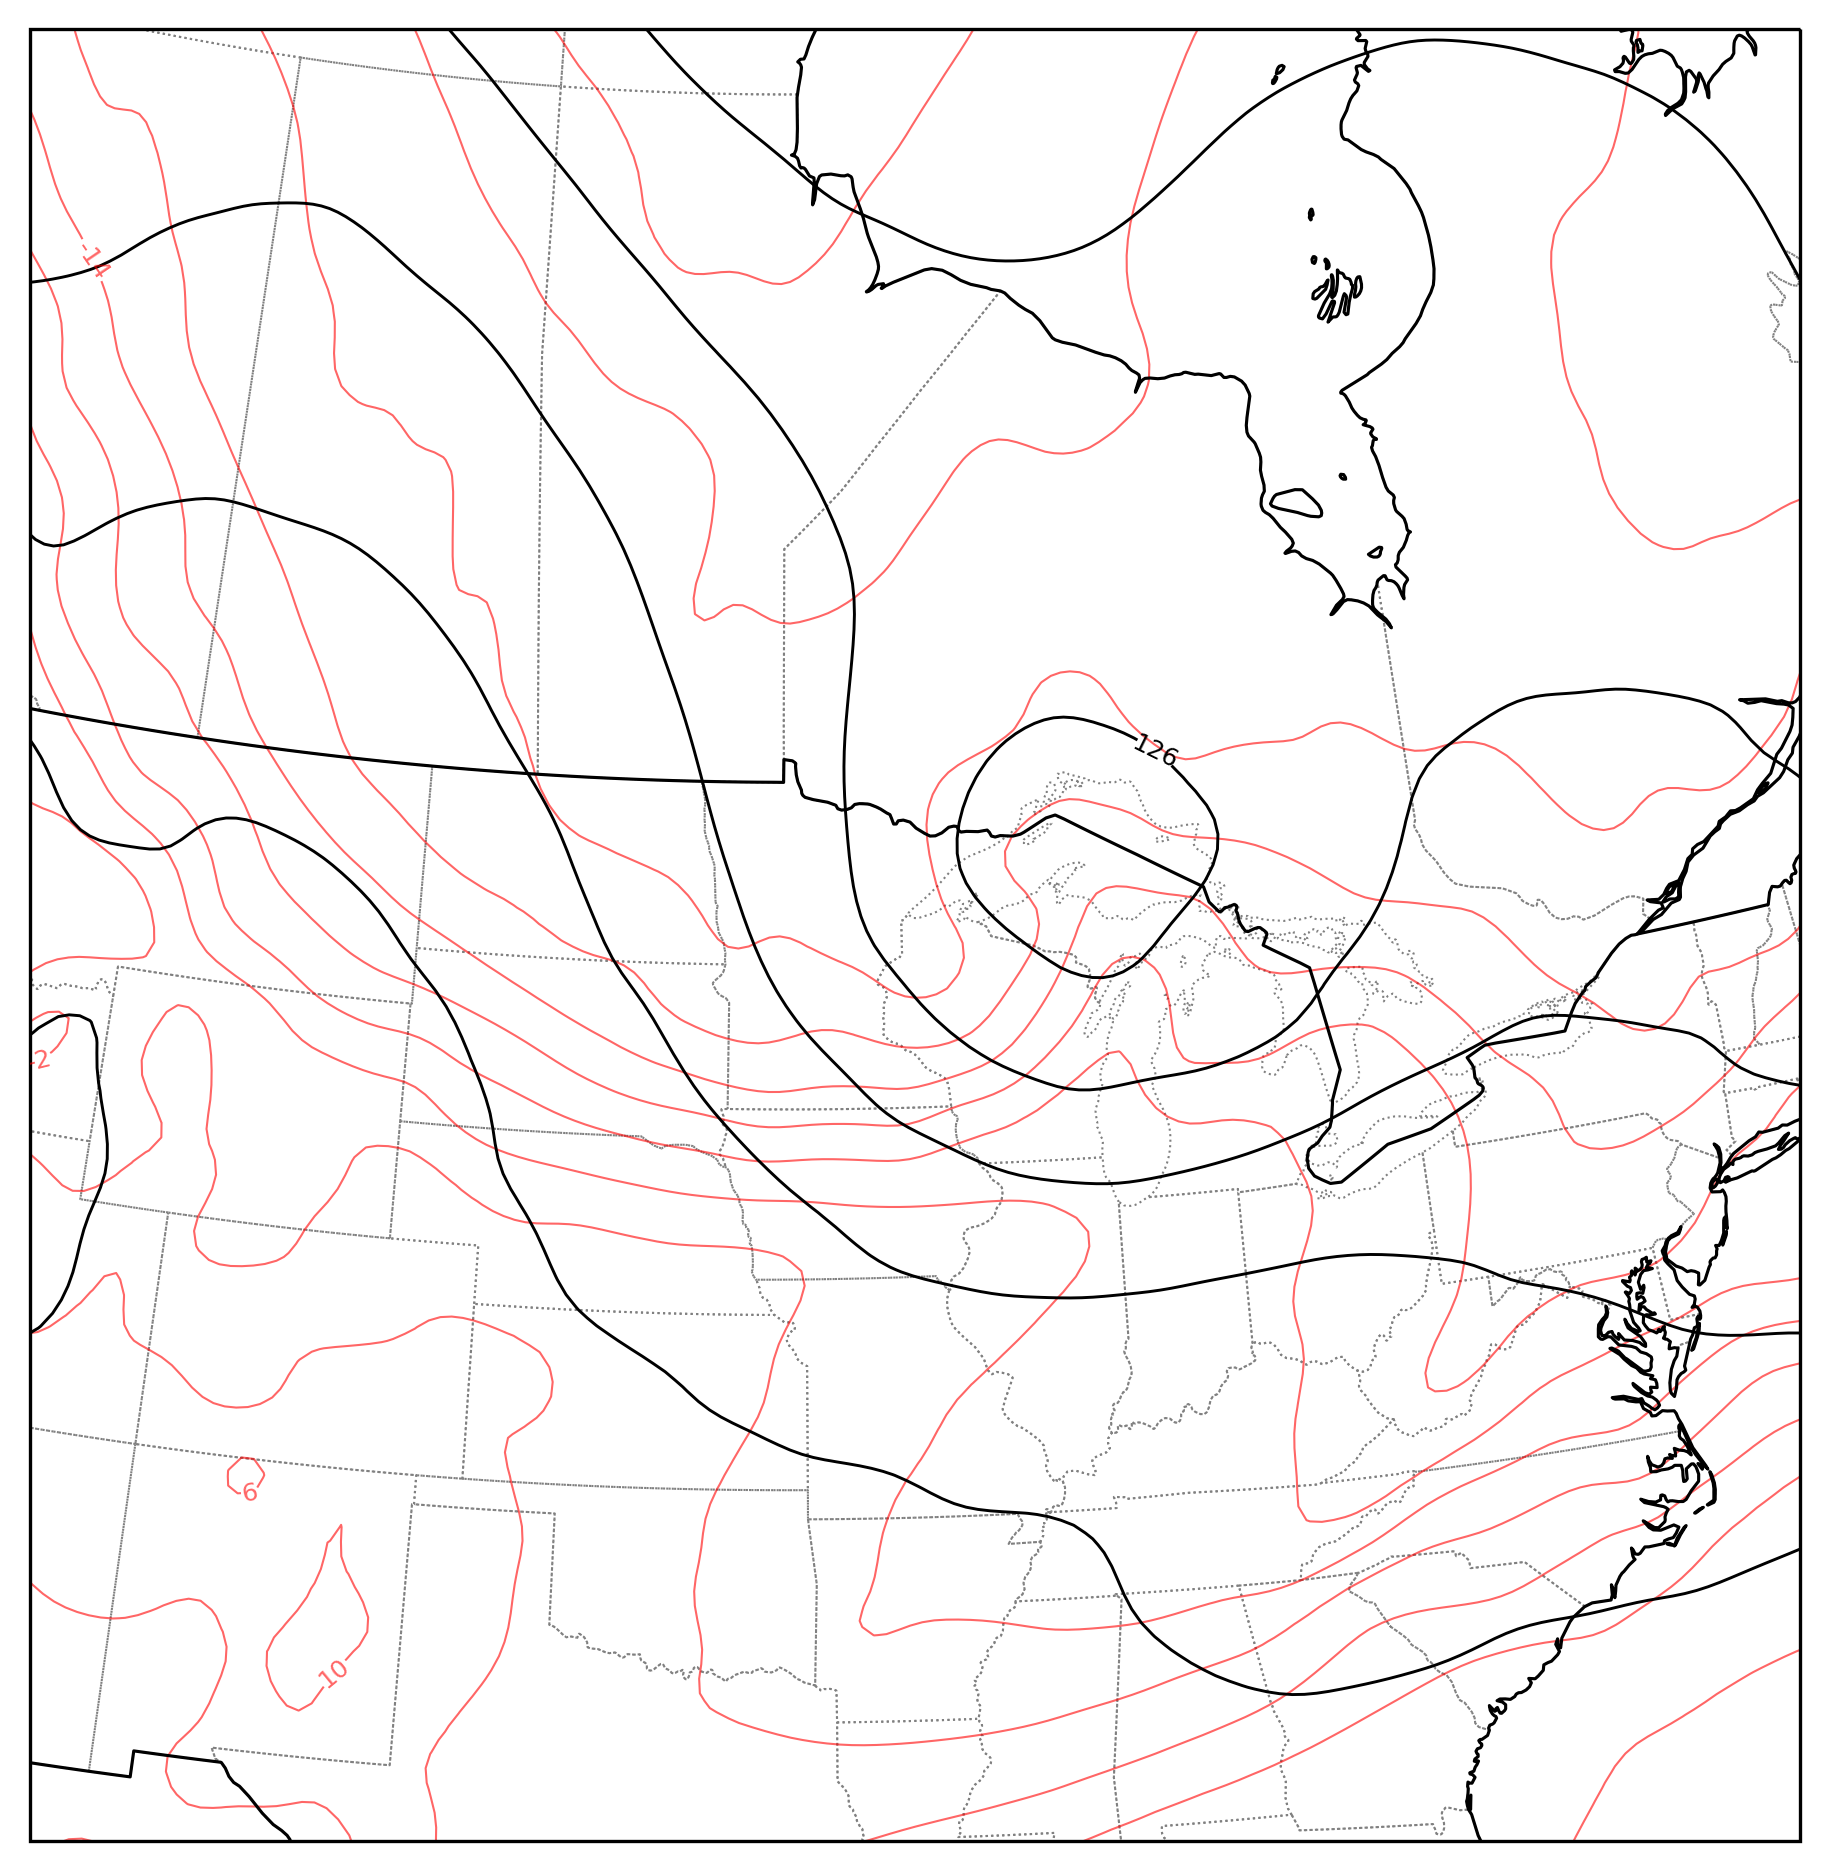

In [26]:
gfs_temp_upper_air_plot(model_data,level,time)

### You have now completed the Python portion of the lab.  Be sure to submit the fully rendered Jupyter Notebook on GitHub when you are finished.